# Kondo Peak Width Evolution with rising Temperature - Numerical Analysis and Kondo Temperature Extraction

This notebook analyzes a series of spectroscopy data files from temperature-dependent experiments. The goal is to fit the data using a newly published program (https://github.com/david-jacob/HurwitzFanoFit) and a fano-fit conducted on my onw. During this procedure I will do an iteration with a temperature-broadened (convoluted) function and once without (unconvoluted):
- **Convoluted Model :** Incorporates temperature convolution.
- **Unconvoluted Model :** A direct fit without convolution.

The notebook is organized as follows:
1. **Environment Setup:** Import necessary libraries and define global variables.
2. **Data Loading & Preprocessing:** Read and normalize the original spectroscopy data.
3. **Curve Fitting:** Perform fits using both models.
4. **Plateau Width:** Check if the fitted plateau width increases linearly -> Kondo characteristic
5. **Konto Temperature Fit:** Plot the normalized dI/dV curves with fitted models and thus extract the Kondo Temperature using the width evolution.
6. **Hurwitz Model:** Extract the Kondo Temperature using the provided model by David Jacob.


1. **Environment Setup:**

In [22]:
# =============================================================================
# Import Necessary Libraries
# =============================================================================
# Import dependencies from the "requirements" module (if applicable).
from requirements import *

# Standard library imports.
import os
import subprocess
from os.path import dirname

# Third-party imports.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from scipy import constants, interpolate, special
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from uncertainties import unumpy

# Custom module imports.
from colors import tol_cset

# =============================================================================
# Plotting Settings and Directory Setup
# =============================================================================
# Set a vibrant color palette using custom color settings.
color = tol_cset('vibrant')

# Determine the working directory and its parent directories.
work_dir = os.getcwd()
parent_dir = dirname(work_dir)
grandparent_dir = dirname(parent_dir)

# Use a custom matplotlib style file (e.g., for a LaTeX thesis) located in the parent directory.
#plt.style.use(os.path.join(parent_dir, 'latex_thesis.mplstyle.txt'))

# Define the Boltzmann constant in eV/K for later use.
kB = constants.physical_constants['Boltzmann constant in eV/K'][0]

# =============================================================================
# Analysis Parameters
# =============================================================================
# Set modulation amplitude (Vm), effective tip temperature (Teff),
# voltage broadening limit (Vbroadlim), fitting start threshold, and phase factor (phi).
Vm = 20e-6         # Modulation amplitude (in V)
Vbroadlim = 6e-4   # Voltage broadening limit (in V)
fit_start = 0.6e-3 # Fitting start threshold (in V)
phi = 0.8          # Phase factor (unitless)


In [2]:

# =============================================================================
# Custom Legend Handler
# =============================================================================
class AnyObjectHandler(HandlerBase):
    """
    Custom handler for legend objects that creates a composite artist.
    """

    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        """
        Create a composite legend artist consisting of two Line2D objects.
        
        Parameters:
            legend: The legend instance.
            orig_handle: The original handle (ignored here).
            x0, y0: Coordinates for the starting point.
            width, height: Dimensions for the artist.
            fontsize: The font size (unused here).
            trans: Transformation (unused here).
        
        Returns:
            A list containing two Line2D objects.
        """
        # First line: black segment
        line1 = plt.Line2D([x0, (x0 + y0 + width) / 2], [0.5 * height, 0.5 * height], color='k')
        # Second line: red segment
        line2 = plt.Line2D([(x0 + y0 + width) / 2, y0 + width], [0.5 * height, 0.5 * height], color='r')
        return [line1, line2]


# =============================================================================
# Frota Functions
# =============================================================================
def frota_function(V, A, phi, gamma0, E_k):
    """
    Computes the Frota function.
    
    Parameters:
        V : array_like
            Voltage array.
        A : float
            Amplitude scaling factor.
        phi : float
            Phase factor.
        gamma0 : float
            Characteristic width parameter.
        E_k : float
            Kondo energy.
    
    Returns:
        array_like: Imaginary part of the Frota function.
    """
    delta_k = gamma0 / 2.542
    return A * np.imag(1j * np.exp(1j * phi) * np.sqrt(1j * delta_k / (V - E_k + 1j * delta_k)))


def frota_function2(V, A, phi, gamma0, E_k):
    """
    Computes an alternative version of the Frota function using the real part.
    
    Parameters:
        V : array_like
            Voltage array.
        A : float
            Amplitude scaling factor.
        phi : float
            Phase factor.
        gamma0 : float
            Characteristic width parameter.
        E_k : float
            Kondo energy.
    
    Returns:
        array_like: Real part of the modified Frota function.
    """
    delta_k = gamma0 / 2.542
    return A * np.real(np.sqrt(1j * delta_k / (V - E_k + 1j * delta_k)))


# =============================================================================
# Hurwitz-Frota Function
# =============================================================================
def hurwitz_frota(V, A, phi, gamma0, T, bkg, m):
    """
    Computes the Hurwitz-Frota function for spectroscopy analysis.
    
    Parameters:
        V : array_like
            Voltage array.
        A : float
            Amplitude factor.
        phi : float
            Phase factor.
        gamma0 : float
            Characteristic width parameter.
        T : float
            Temperature (in Kelvin).
        bkg : float
            Background offset.
        m : float
            Linear slope term.
    
    Returns:
        numpy.ndarray: Processed differential conductance values.
    """
    delta_k = gamma0 / 2.542
    # Calculate tau using Boltzmann constant in eV/K
    tau = np.pi * constants.physical_constants['Boltzmann constant in eV/K'][0] * T
    # Compute the differential conductance using the Hurwitz zeta function
    didv = [
        A * np.sqrt(delta_k / (8 * tau)) * np.real(np.exp(1j * phi) *
            special.zeta(3/2, delta_k / (2 * tau) + 0.5 + 1j * Vi / (2 * tau)))
        + bkg + m * Vi for Vi in V
    ]
    return np.array(didv, dtype=float)


# =============================================================================
# Gamma-T Relations
# =============================================================================
def gamma_kondo(T, gamma0):
    """
    Computes the Kondo width as a function of temperature.
    
    Parameters:
        T : float
            Temperature (in Kelvin).
        gamma0 : float
            Zero-temperature width parameter.
    
    Returns:
        float: Temperature-dependent Kondo width.
    """
    delta_k = gamma0 / 2.542
    a = 1 + np.sqrt(3)
    b = 2 + np.sqrt(3)
    c = np.sqrt(3) / 2
    k = constants.physical_constants['Boltzmann constant in eV/K'][0]
    gamma = delta_k * np.sqrt(a + b * np.sqrt(1 + (np.pi * k * T / delta_k) ** 2) + c * (np.pi * k * T / delta_k) ** 2)
    return gamma


def gamma_kondo_short(T, gamma0):
    """
    Computes a simplified temperature-dependent Kondo width.
    
    Parameters:
        T : float
            Temperature (in Kelvin).
        gamma0 : float
            Zero-temperature width parameter.
    
    Returns:
        float: Simplified temperature-dependent Kondo width.
    """
    k = constants.physical_constants['Boltzmann constant in eV/K'][0]
    alpha = 5.193
    gamma = np.sqrt(gamma0 ** 2 + (alpha * k * T) ** 2)
    return gamma


# =============================================================================
# ZPC (Zero-Point Conductance) Function
# =============================================================================
def zpc_function(T, T_K, G_0):
    """
    Computes the zero-point conductance function.
    
    Parameters:
        T : float
            Temperature (in Kelvin).
        T_K : float
            Kondo temperature.
        G_0 : float
            Conductance scale factor.
    
    Returns:
        float: Zero-point conductance.
    """
    s = 0.22
    bkg = 0.000
    return G_0 / (1 + (2 ** (1 / s) - 1) * (T / T_K) ** 2) ** s + bkg


# =============================================================================
# Individual Temperature Kondo Spectrum Functions
# =============================================================================
def individual_Tk(T, gamma):
    """
    Converts an individual temperature Kondo spectrum to a corresponding width.
    
    Parameters:
        T : float
            Temperature (in Kelvin).
        gamma : float
            Gamma parameter.
    
    Returns:
        float: Converted Kondo width.
    """
    alpha = (2 + np.sqrt(3)) / 6
    beta = 1 - 1 / np.sqrt(12)
    g = 1 - 1 / np.sqrt(3)
    tau = np.pi * constants.physical_constants['Boltzmann constant in eV/K'][0] * T
    delta_k = np.sqrt(np.sqrt(1 / 3 * gamma ** 4 + 1 / 3 * tau ** 2 * gamma ** 2 + alpha * tau ** 4) - beta * tau ** 2 - g * gamma ** 2)
    return delta_k * 2.542


def individual_Tk_er(T, gamma):
    """
    Similar to individual_Tk but returns a value with uncertainty.
    
    Parameters:
        T : float
            Temperature (in Kelvin).
        gamma : float
            Gamma parameter with uncertainty.
    
    Returns:
        uncertainties.core.AffineScalarFunc: Converted Kondo width with uncertainty.
    """
    alpha = (2 + np.sqrt(3)) / 6
    beta = 1 - 1 / np.sqrt(12)
    g = 1 - 1 / np.sqrt(3)
    tau = np.pi * constants.physical_constants['Boltzmann constant in eV/K'][0] * T
    delta_k = unumpy.sqrt(unumpy.sqrt(1 / 3 * gamma ** 4 + 1 / 3 * tau ** 2 * gamma ** 2 + alpha * tau ** 4) - beta * tau ** 2 - g * gamma ** 2)
    return delta_k * 2.542


# =============================================================================
# Modulation and Temperature Broadening Functions
# =============================================================================
def f_mod(V, Vm):
    """
    Computes the modulation broadening function.
    
    Parameters:
        V : array_like
            Voltage array.
        Vm : float
            Modulation amplitude.
    
    Returns:
        numpy.ndarray: Broadening factor for each voltage.
    """
    return np.array([2 * np.sqrt(Vm ** 2 - Vi ** 2) / (np.pi * Vm ** 2) if np.abs(Vi) <= Vm else 0 for Vi in V])


def f_T(V, T):
    """
    Computes the temperature broadening function.
    
    Parameters:
        V : array_like
            Voltage array.
        T : float
            Temperature (in Kelvin).
    
    Returns:
        numpy.ndarray: Temperature broadening factors.
    """
    k = constants.physical_constants['Boltzmann constant in eV/K'][0]
    beta = 1 / (k * T)
    return np.array([beta / (4 * (np.cosh(beta * Vi / 2)) ** 2) for Vi in V])


# =============================================================================
# Effective Temperature Functions
# =============================================================================
def get_Teff_sample(T):
    """
    Computes the effective sample temperature.
    
    Parameters:
        T : float
            Measured temperature.
    
    Returns:
        float: Effective sample temperature.
    """
    # The formula is piecewise; below 60 mK, a plateau is used.
    if T < 0.06:
        return 0.150  # Plateau below 60 mK
    else:
        return 0.63 * T + 0.13


def get_Teff_tip(T):
    """
    Computes the effective tip temperature.
    
    Parameters:
        T : float
            Measured tip temperature.
    
    Returns:
        float: Effective tip temperature.
    """
    return T + 0.045


# =============================================================================
# Fitting Range Helper Function
# =============================================================================
def get_fitrange(V, fit_edge, fit_start=None):
    """
    Determines the fit range based on voltage edges.
    
    Parameters:
        V : array_like
            Voltage array.
        fit_edge : float
            Voltage offset from the edges to exclude from the fit.
        fit_start : float, optional
            Additional limit on the voltage (if provided).
    
    Returns:
        numpy.ndarray: Boolean array marking the fit range.
    """
    V0, Vend = V[0], V[-1]
    if fit_start is None:
        fit_range = (np.abs(V - V0) > fit_edge) & (np.abs(V - Vend) > fit_edge)
    else:
        fit_range = (np.abs(V - V0) > fit_edge) & (np.abs(V - Vend) > fit_edge) & (np.abs(V) < fit_start)
    return fit_range


# =============================================================================
# Additional Functions
# =============================================================================
def nagoka_function(T, gamma0):
    """
    Computes the Nagoka function for temperature-dependent broadening.
    
    Parameters:
        T : float
            Temperature (in Kelvin).
        gamma0 : float
            Characteristic width parameter.
    
    Returns:
        float: Calculated value based on the Nagoka function.
    """
    k = constants.physical_constants['Boltzmann constant in eV/K'][0]
    alpha = 2 * np.pi
    return 0.5 * np.sqrt((2 * gamma0) ** 2 + (alpha * k * T) ** 2)


def log_function(V, A, phi, gamma0, E_k):
    """
    Computes a logarithmic function ( for convolution).
    
    Parameters:
        V : array_like
            Voltage array.
        A : float
            Amplitude.
        phi : float
            Phase factor.
        gamma0 : float
            Characteristic width parameter.
        E_k : float
            Kondo energy.
    
    Returns:
        array_like: Logarithmic function output.
    """
    return A * np.log(V * phi)


def convolution(f, bias, Vbroadlim, Vm, fit_edge, fit_start, A, phi, FWHM, E_k, bkg, m, T,
                fit_return=False, Tconv=True, modconv=True):
    """
    General convolution function to process spectroscopy data.
    
    This function convolves the given function f with temperature and modulation
    broadening functions and applies additional offsets.
    
    Parameters:
        f : function
            The function to be convolved.
        bias : array_like
            The bias voltage array.
        Vbroadlim : float
            Voltage limit for broadening.
        Vm : float
            Modulation amplitude.
        fit_edge : float
            Edge exclusion for fitting.
        fit_start : float or None
            Additional voltage limit for the fitting range.
        A, phi, FWHM, E_k, bkg, m : float
            Parameters for the function f and offsets.
        T : float
            Temperature (in Kelvin).
        fit_return : bool, optional
            If True, returns interpolated fit data on the bias grid.
        Tconv : bool, optional
            If True, perform temperature convolution.
        modconv : bool, optional
            If True, perform modulation convolution.
    
    Returns:
        array_like: The convolved function evaluated on the fitting range.
    """
    # Determine voltage range
    bias_min, bias_max = bias.min(), bias.max()
    V = np.linspace(bias_min, bias_max, num=len(bias) * 5) if fit_return else bias

    # Shift voltage array to center it
    Vshift = V - (V.max() + V.min()) / 2
    Vbroad = Vshift[np.abs(Vshift) < Vbroadlim]

    # Determine fit range based on edges
    fit_range = get_fitrange(V, fit_edge, fit_start)
    
    # Evaluate the function f on V
    func = f(V, A, phi, FWHM, E_k)
    
    # Apply temperature convolution if enabled
    if Tconv:
        temp_conv = f_T(Vbroad, T)
        func = np.convolve(func, temp_conv, mode='same') / np.sum(temp_conv)
    
    # Apply modulation convolution if enabled
    if modconv:
        mod_conv = f_mod(Vbroad, Vm)
        func = np.convolve(func, mod_conv, mode='same') / np.sum(mod_conv)
    
    # Add background and linear term
    func += bkg + m * V
    
    if fit_return:
        interp_f = interpolate.interp1d(V, func)
        fit_range = get_fitrange(bias, fit_edge, fit_start)
        return interp_f(bias[fit_range])
    else:
        return func[fit_range]


2. **Data Loading & Preprocessing:**

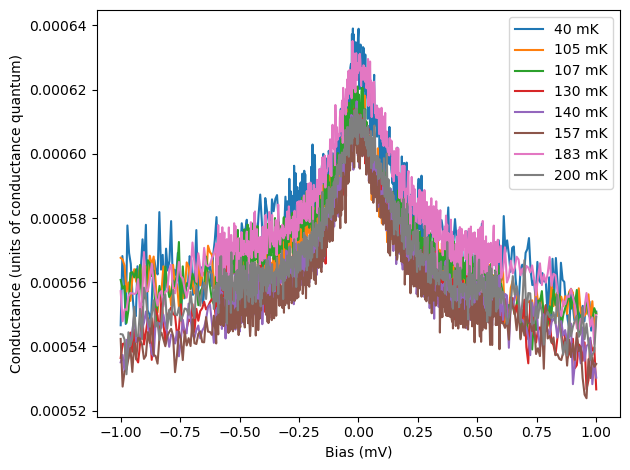

In [23]:
def process_spectroscopy_data():
    """
    Processes single-sweep spectroscopy data, converts it to units of the conductance quantum,
    and plots the results.

    The function:
      - Loads data from spectroscopy files stored in a specified folder.
      - Processes multiple temperature sweeps for selected temperatures.
      - Applies normalization and correction factors based on edge averages.
      - Converts the measured differential conductance to units of the conductance quantum.
      - Generates a plot of the processed data.
    """
    # Set folder containing spectroscopy files
    folder = r'original_specs'
    
    # Define temperature values (in mK) to process; here, the first 8 unique temperatures are selected.
    Ts = np.setdiff1d([40, 105, 107, 130, 140, 157, 183, 200, 215, 230, 255, 305, 365, 445, 520, 545, 580, 610, 640, 670, 700, 740, 760], [])[:8]
    
    # Loop over each temperature
    for idx, T in enumerate(Ts):
        # Construct the filename based on the temperature value (e.g., "kondo040mK.dat" for T=40 mK)
        filename = 'kondo' + '{:03d}'.format(T) + 'mK.dat'
        header, channel = spec.getSpectroscopyData(folder, filename)
        
        # Extract bias, current, and average data from the spectroscopy channel
        # Bias is scaled (divided by 100) to obtain the correct units
        bias = channel[:, 0] / 100
        current = channel[:, 1]
        avg_data = channel[:, 2]
        px_num = len(bias)
        sweeps = 10  # Maximum number of sweeps to consider
        
        # Initialize an array to accumulate the differential conductance data (didv)
        data = np.zeros(px_num)
        real_sweeps = 1  # Counter for the number of valid sweeps processed
        
        # Define edge regions for normalization (right and left edges)
        r_edg = (0.0008 < bias) & (bias < 0.001)
        l_edg = (bias < -0.0008) & (bias > -0.001)
        
        # Loop over the sweep indices (starting at sweep=4, then stepping by 3)
        for sweep in [4 + 3 * j for j in range(sweeps)]:
            # If the file contains only 4 columns (i.e. no single-sweep data), skip detailed processing.
            if len(channel[1]) == 4:
                first_current = current
                correction_factor = np.linspace(1, abs(first_current[r_edg].mean() / first_current[l_edg].mean()),
                                                num=px_num, endpoint=True)
                data = avg_data * correction_factor
                first_current = first_current * correction_factor
                break
            # Special handling for 610 mK files with different file type
            elif T == 610:
                first_current = current
                correction_factor = np.linspace(1, abs(first_current[r_edg].mean() / first_current[l_edg].mean()),
                                                num=px_num, endpoint=True)
                data = avg_data * correction_factor
            else:
                try:
                    # Check if the current sweep has valid data (nonzero at the end)
                    if channel[:, sweep + 1][-1] != 0.0:
                        current = channel[:, sweep]
                        sweep_data = channel[:, sweep + 1]
                        if sweep == 4:
                            # Use the first valid sweep for normalization
                            first_current = current
                            start_norm = first_current[r_edg].mean()
                            stop_norm = first_current[r_edg].mean()  # Here, both are set equal
                            first_correction_factor = np.linspace(1, abs(start_norm / first_current[l_edg].mean()),
                                                                  num=px_num, endpoint=True)
                            sweep_data *= first_correction_factor
                            data += sweep_data
                        else:
                            # Correct subsequent sweeps based on the first sweep's edge values
                            correction_factor = np.linspace(start=first_current[r_edg].mean() / current[r_edg].mean(),
                                                            stop=abs(first_current[r_edg].mean() / current[l_edg].mean()),
                                                            num=px_num, endpoint=True)
                            sweep_data *= correction_factor
                            data += sweep_data
                            real_sweeps += 1
                except (SyntaxError, IndexError):
                    # If an error occurs (e.g., missing sweep data), skip this sweep
                    pass
        
        # Average the data over the number of valid sweeps
        data = data / real_sweeps
        bias_range_mean = np.average(bias[r_edg])
        current_range_mean = np.average(first_current[r_edg])
        data_range_mean = np.average(data[r_edg])
        
        # Convert the data to conductance quantum units:
        # Compute the overall conductance (current divided by bias) and a conversion factor based on the measured data
        conductance = current_range_mean / bias_range_mean
        conversion_factor = conductance / data_range_mean
        data = data * conversion_factor / constants.physical_constants['conductance quantum'][0]
        
        # Plot the processed data for the current temperature (convert bias to mV for plotting)
        plt.plot(bias * 1000, data, label=f"{T} mK")
    
    # Finalize plot with labels, legend, and layout adjustments
    plt.xlabel("Bias (mV)")
    plt.ylabel("Conductance (units of conductance quantum)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Execute the data processing function
process_spectroscopy_data()


3. **Curve Fitting:**

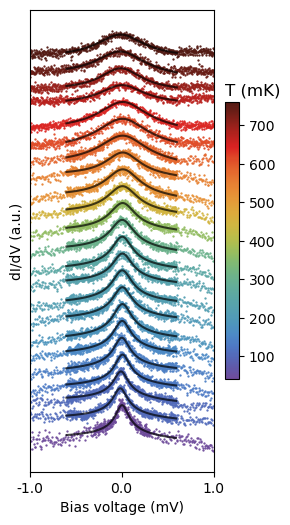

In [4]:
def kondo_series_frota_fit():
    """
    Processes a series of spectroscopy data files, fits the Frota function to the data,
    and plots the normalized differential conductance (dI/dV) curves as a function of bias.
    
    The function performs two fits per temperature:
      - A convoluted (processed) fit.
      - An unconvoluted (natural) fit.
    
    Returns:
        tuple: A 4-tuple containing:
            - params_conv (list): Fitted parameters from the convoluted model for each temperature.
            - errors_conv (list): Uncertainties (standard deviations) for the convoluted fit parameters.
            - params_unconv (list): Fitted parameters from the unconvoluted model for each temperature.
            - errors_unconv (list): Uncertainties for the unconvoluted fit parameters.
    """

    # Define folder and temperatures to process (in mK)
    folder = r'halfnormed_specs'
    Ts = np.array([40, 105, 107, 130, 140, 157, 183, 200, 215, 230, 255, 305, 365, 445, 520, 545, 580, 610, 640, 670, 700, 740, 760])
    
    # Create a figure for plotting
    fig, ax = plt.subplots(figsize=(5.94/2, 9*2/3))
    
    # Define fitting boundaries – Vbroadlim must be defined externally.
    fit_start = 6e-4
    fit_edge = Vbroadlim * 2 / 3
    
    # Lists to store fitted parameters and errors for convoluted and unconvoluted fits.
    params_conv = []
    errors_conv = []
    params_unconv = []
    errors_unconv = []
    
    # Loop over each temperature file.
    for idx, T in enumerate(Ts):
        # Construct filename (e.g., "040mK.dat" for T=40 mK)
        filename = '{:03d}mK.dat'.format(T)
        header, channel = spec.getSpectroscopyData(folder, filename)
        
        # Extract data columns: bias, current, and differential conductance.
        bias = channel[:, 0]
        current = channel[:, 1]
        data = channel[:, 2].flatten()
        
        # Compute effective tip temperature (convert mK to K)
        Teff = get_Teff_tip(T / 1000)
        
        # Choose a color based on temperature using tol_cmap (assumed defined elsewhere)
        colour = tol_cmap('rainbow_PuBr')((T - Ts.min()) / (Ts.max() - Ts.min()))
        
        # Normalize the data using the average around the peak.
        peak_index = np.argmax(data)
        datamax = data[peak_index - 20: peak_index + 20].mean()
        data = data / datamax
        
        # Determine the fitting range using a helper function (get_fitrange)
        mask = get_fitrange(bias, fit_edge, fit_start)
        
        # Define lambda functions for curve fitting:
        # Unconvoluted fit (natural model): without temperature and modulation convolution.
        fit_noconv_frota = lambda V, A, E_k, FWHM, bkg, m: convolution(
            frota_function2, V, Vbroadlim, Vm, fit_edge, fit_start,
            A, phi, FWHM, E_k, bkg, m, Teff,
            fit_return=True, Tconv=False, modconv=False)
        
        # Convoluted fit (processed model): includes convolution.
        fit_conv_frota = lambda V, A, E_k, FWHM, bkg, m: convolution(
            frota_function2, V, Vbroadlim, Vm, fit_edge, fit_start,
            A, phi, FWHM, E_k, bkg, m, Teff,
            fit_return=True)
        
        # Use an initial guess for the first temperature; then use previous fit as initial guess.
        if idx == 0:
            p0 = [2, 0.0, 1e-4, 0.0, 0.0]
        else:
            p0 = popt  # from previous iteration
        
        # Perform curve fitting on the selected bias range.
        popt, fit_cov = optimize.curve_fit(fit_conv_frota, bias, data[mask], p0=p0)
        popt_noconv, fit_nocov = optimize.curve_fit(fit_noconv_frota, bias, data[mask], p0=p0)
        
        # Store the fitted parameters and their uncertainties.
        params_conv.append(popt)
        errors_conv.append(np.sqrt(np.diag(fit_cov)))
        params_unconv.append(popt_noconv)
        errors_unconv.append(np.sqrt(np.diag(fit_nocov)))
        
        # Evaluate the fitted functions over the entire bias range.
        fit = fit_conv_frota(bias, *popt)
        fit_natural = fit_noconv_frota(bias, *popt)
        
        # Create a general bias array for visualization.
        general_bias = np.linspace(-0.001, 0.001, 1000)
        general_fitrange = general_bias[get_fitrange(general_bias, fit_edge, fit_start)]
        
        # Evaluate the convoluted fit over the general bias array.
        fit_general = fit_conv_frota(general_bias, *popt)
        bias_plateau = general_fitrange[fit_general > 0.99]
        fit_plateau = fit_general[fit_general > 0.99]
        
        # Plot the convoluted fit (raw fit) with a vertical offset.
        ax.plot(bias[mask], fit / fit.max() + 0.05 * idx, alpha=0.7, color='k')
        
        # Plot the experimental data as a scatter plot.
        ax.scatter(bias, data / fit.max() + 0.05 * idx, s=0.4, color=colour)
    
    # Format the x-axis ticks: display bias values in mV.
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(np.round(ax.get_xticks() * 1e3, 2))
    ax.set_ylabel('dI/dV (a.u.)')
    ax.set_yticks([])
    ax.set_xlabel('Bias voltage (mV)')
    ax.set_xlim(-0.001, 0.001)
    
    # Create a colorbar to indicate temperature (in mK)
    scalarmappable = cm.ScalarMappable(cmap=tol_cmap('rainbow_PuBr'), norm=plt.Normalize(Ts.min(), Ts.max()))
    scalarmappable.set_array([])
    cbar = plt.colorbar(scalarmappable, ax=ax, shrink=0.6, ticks=[100, 200, 300, 400, 500, 600, 700])
    cbar.ax.set_title('T (mK)', loc='left', pad=5)
    
    plt.show()
    
    # Return the fitted parameters and their errors for both models.
    return params_conv, errors_conv, params_unconv, errors_unconv

# Execute the function and print the returned fit parameters and errors.
params_conv, errors_conv, params_unconv, errors_unconv = kondo_series_frota_fit()



4. **Plateau Width:**

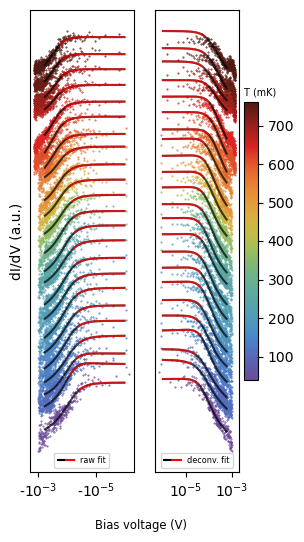

In [17]:
def kondo_hat_plateau():
    """
    Process Kondo spectroscopy data ("hat plateau") from a set of files,
    fit the Frota function, extract plateau widths, and plot the results on
    two axes (left: raw fit; right: deconvolved fit). The left plot uses 
    the absolute negative bias (log-scaled) and the right plot uses the 
    positive bias.
    
    Returns:
        tuple: A 4-tuple containing:
            - plateau_width (list): Plateau widths from the raw (convolved) fit.
            - plateau_width_natural (list): Plateau widths from the deconvolved fit.
            - fit_params_unconv (list): Unconvoluted fitted parameters for each temperature.
            - fit_errors_unconv (list): Corresponding errors for the unconvoluted fitted parameters.
    """
    # Define folder and temperatures to process (in mK)
    folder = r'halfnormed_specs'
    Ts = np.array([40, 105, 107, 130, 140, 157, 183, 200, 215, 230, 255, 305, 365, 445, 520, 545, 580, 610, 640, 670, 700, 740, 760])
    smoothing_param = dict(wl=50, po=2)

    # Create a figure with two subplots (left: raw fit, right: deconvolved fit)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.94/2, 9*2/3))
    
    # Define fit parameters for the fitting routine
    fit_start = 6e-4
    fit_edge = Vbroadlim * 2 / 3
    
    # Load pre-saved fit parameters and errors from files
    params = params_conv
    errors = errors_conv
    
    # Initialize lists for plateau widths and unconvoluted fit results
    plateau_width = []
    plateau_width_natural = []
    fit_params_unconv = []
    fit_errors_unconv = []
    
    # Process each temperature file
    for idx, T in enumerate(Ts):
        filename = '{:03d}mK.dat'.format(T)
        header, channel = spec.getSpectroscopyData(folder, filename)
        
        # Extract data columns: bias, current, and differential conductance (dI/dV)
        bias = channel[:, 0]
        current = channel[:, 1]
        data = channel[:, 2].flatten()
        
        # Compute effective tip temperature (convert mK to K)
        Teff = get_Teff_tip(T / 1000)
        # Choose a color based on temperature
        colour = tol_cmap('rainbow_PuBr')((T - Ts.min()) / (Ts.max() - Ts.min()))
        
        # Define lambda functions for fitting:
        # - Without convolution (natural/unconvoluted fit)
        # - With convolution (processed fit)
        fit_noconv_frota = lambda V, A, E_k, FWHM, bkg, m: convolution(
            frota_function2, V, Vbroadlim, Vm, fit_edge, fit_start,
            A, phi, FWHM, E_k, bkg, m, Teff, fit_return=True, Tconv=False, modconv=False)
        fit_conv_frota = lambda V, A, E_k, FWHM, bkg, m: convolution(
            frota_function2, V, Vbroadlim, Vm, fit_edge, fit_start,
            A, phi, FWHM, E_k, bkg, m, Teff, fit_return=True)
        
        # Use the previous fit as the initial guess for subsequent fits
        if idx == 0:
            p0 = [2, 0.0, 1e-4, 0.0, 0.0]
        else:
            p0 = popt
        
        # Retrieve unconvoluted fit parameters from pre-saved params for demonstration.
        # Store these parameters and their errors for future use.
        popt = params[idx]
        fit_params_unconv.append(popt)
        fit_errors_unconv.append(errors[idx])
        
        # Normalize the data using the average around the peak
        peak_index = np.argmax(data)
        datamax = data[peak_index - 20: peak_index + 20].mean()
        data = data / datamax
        
        # Create a general bias array for fitting
        general_bias = np.linspace(-0.001, 0.001, 1000)
        general_fitrange = general_bias[get_fitrange(general_bias, fit_edge, fit_start)]
        
        # Evaluate fitted functions over the general bias range
        fit = fit_conv_frota(general_bias, *popt)
        fit_natural = fit_noconv_frota(general_bias, *popt)
        
        # Extract plateau regions (where fit values are near maximum)
        bias_plateau = general_fitrange[fit > 0.99]
        fit_plateau = fit[fit > 0.99]
        bias_natural_plateau = general_fitrange[fit_natural > 0.99 * fit_natural.max()]
        fit_natural_plateau = fit_natural[fit_natural > 0.99 * fit_natural.max()]
        
        # Compute plateau widths and store them for future use
        plateau_width.append(bias_plateau.max() - bias_plateau.min())
        plateau_width_natural.append(bias_natural_plateau.max() - bias_natural_plateau.min())
        
        # Separate bias into negative and positive parts for plotting
        neg_bias = bias < 0
        pos_bias = bias > 0

        # --- Left Plot: Raw Fit (Negative Bias) ---
        ax1.scatter(np.abs(bias[neg_bias]), data[neg_bias] + 0.03 * idx, s=.2,color=colour)
        ax1.plot(np.abs(general_fitrange[general_fitrange < 0]), fit[general_fitrange < 0] + 0.03 * idx,
                 color='black', alpha=0.7)
        ax1.plot(np.abs(bias_plateau[bias_plateau < 0]), fit_plateau[bias_plateau < 0] + 0.03 * idx,
                 color='red', alpha=0.7)
        ax1.legend([object], ['raw fit'], handler_map={object: AnyObjectHandler()}, loc='lower center', fontsize='xx-small')
        
        # --- Right Plot: Deconvolved Fit (Positive Bias) ---
        ax2.scatter(bias[pos_bias], data[pos_bias] + 0.03 * idx, s=.2, color=colour)
        ax2.plot(np.abs(general_fitrange[general_fitrange > 0]), fit_natural[general_fitrange > 0] + 0.03 * idx,
                 color='black', alpha=0.7)
        ax2.plot(np.abs(bias_natural_plateau[bias_natural_plateau > 0]), fit_natural_plateau[bias_natural_plateau > 0] + 0.03 * idx,
                 color='red', alpha=0.7)
        ax2.legend([object], ['deconv. fit'], handler_map={object: AnyObjectHandler()}, loc='lower center', fontsize='xx-small')

    # Set log scales and formatting for the axes
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax1.set_ylabel('dI/dV (a.u.)')
    
    # Sync left axis ticks with right axis (with sign inversion)
    ax1.set_xticks(ax2.get_xticks(), ['-' + label.get_text() for label in ax2.get_xticklabels()])
    ax1.set_xlim(ax2.get_xlim())
    ax1.invert_xaxis()
    
    # Set overall x-axis label
    fig.supxlabel('Bias voltage (V)', fontsize='small')
    
    # Create a colorbar indicating temperature (in mK)
    scalarmappable = cm.ScalarMappable(cmap=tol_cmap('rainbow_PuBr'), norm=plt.Normalize(Ts.min(), Ts.max()))
    scalarmappable.set_array([])
    cbar = plt.colorbar(scalarmappable, ax=ax2, shrink=0.6, ticks=[100, 200, 300, 400, 500, 600, 700])
    cbar.ax.set_title('T (mK)', loc='left', pad=5, fontsize='x-small')
    
    
    plt.show()
    
    # Return plateau widths, unconvoluted fit parameters, and their errors for future use
    return plateau_width, plateau_width_natural, fit_params_unconv, fit_errors_unconv

# Execute the plateau analysis and store the outputs for future purposes
raw_plateau_width, deconv_plateau_width, unconv_fit_params, unconv_fit_errors = kondo_hat_plateau()



C:\Users\Valentin Maissen\AppData\Local\Temp\ipykernel_2740\928522806.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks() * 1e3, 2))


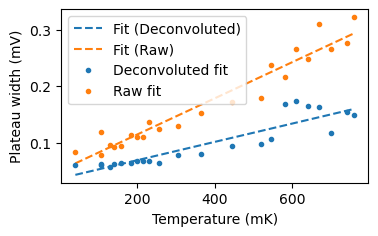

In [ ]:
def plot_plateau_width_evolution(temperatures, deconv_plateau_width, raw_plateau_width):
    """
    Plots the evolution of plateau width as a function of temperature.
    
    Args:
        temperatures (np.array): Array of temperatures in mK.
        deconv_plateau_width (np.array): Array of deconvoluted plateau widths.
        raw_plateau_width (np.array): Array of raw plateau widths.
    """
    fig, ax = plt.subplots(figsize=(5.94*2/3, 9*1/4))

    # Define linear fit function
    fit_lin = lambda x, a, b: a*x + b

    # Perform curve fitting
    popt, pcov = optimize.curve_fit(fit_lin, temperatures, deconv_plateau_width)
    popt2, pcov2 = optimize.curve_fit(fit_lin, temperatures, raw_plateau_width)

    # Plot the linear fits
    ax.plot(temperatures, fit_lin(temperatures, *popt), '--', label='Fit (Deconvoluted)', color='C0')
    ax.plot(temperatures, fit_lin(temperatures, *popt2), '--', label='Fit (Raw)', color='C1')

    # Plot the data points
    ax.plot(temperatures, deconv_plateau_width, 'o', label='Deconvoluted fit', color='C0', ms=3)
    ax.plot(temperatures, raw_plateau_width, 'o', label='Raw fit', color='C1', ms=3)

    # Set labels and legend
    ax.set_xlabel('Temperature (mK)')
    ax.set_ylabel('Plateau width (mV)')
    ax.legend()

    # Format y-axis tick labels
    ax.set_yticklabels(np.round(ax.get_yticks() * 1e3, 2))

    plt.show()

# Example usage
temperatures = np.array([40, 105, 107, 130, 140, 157, 183, 200, 215, 230, 255, 305, 365, 445, 520, 545, 580, 610, 640, 670, 700, 740, 760])


plot_plateau_width_evolution(temperatures, deconv_plateau_width, raw_plateau_width)

5. **Konto Temperature Fit:**

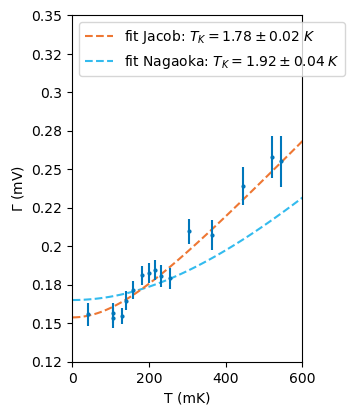

Jacobian Fit Parameters: [0.00015375]
Jacobian T_K: 1.7842232903399877
Jacobian Error: 0.023186926122779755
Nagaoka Fit Parameters: [0.00016506]


In [7]:
def plot_kondo_peak_width_and_fit():
    """
    Plot the Kondo peak width versus temperature and fit the data using two models:
    gamma_kondo (Jacobian) and nagoka_function. The function loads pre-saved fit
    parameters and errors, extracts the peak width from these parameters, performs
    curve fitting for temperatures under 500 mK, and creates a plot with error bars
    and fitted curves.
    
    Returns:
        dict: A dictionary containing the following keys:
              - 'popt_jacobian': Fitted parameters for gamma_kondo.
              - 'pcov_jacobian': Covariance matrix for gamma_kondo fit.
              - 'popt_nagaoka': Fitted parameters for nagoka_function.
              - 'pcov_nagaoka': Covariance matrix for nagoka_function fit.
              - 'Teffs': Effective temperatures in K.
              - 'width': Extracted widths.
              - 'width_err': Errors on the widths.
              - 'Jacob_Tk': The Jacobian T_K value.
              - 'Jacob_error': The uncertainty in the Jacobian T_K.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import optimize, constants
    import matplotlib.cm as cm

    # Define Boltzmann constant in eV/K
    kB = constants.physical_constants['Boltzmann constant in eV/K'][0]
    
    # Define the temperature range for the fit curve (in Kelvin for plotting fits)
    # (Ts is defined as temperatures in mK)
    Ts = np.array([40, 105, 107, 130, 140, 157, 183, 200, 215, 230, 255, 305, 365, 445, 520, 545, 580, 610, 640, 670, 700, 740, 760])
    Teffs = np.array([T_val / 1000 for T_val in Ts])
    
    # Load pre-saved fit parameters and errors from files.
    # (Assumed these files contain results from previous analyses.)
    params = params_conv
    errors = errors_conv
    
    # Extract the peak width and its error from the fit parameters.
    # Assuming the third column (index 2) corresponds to the peak width.
    width = np.array([params[i][2] for i in range(len(params))])
    width_err = np.array([errors[i][2] for i in range(len(errors))])
    
    # Create a boolean mask for temperatures under 500 mK.
    under_500_idx = Ts < 500
    
    # Define a color scheme using tol_cset (assumed defined elsewhere).
    color = tol_cset('vibrant')
    
    # Perform curve fits using gamma_kondo and nagoka_function models.
    popt_jacobian, pcov_jacobian = optimize.curve_fit(
        gamma_kondo, Teffs[under_500_idx], width[under_500_idx],
        sigma=width_err[under_500_idx], p0=[1e-5]
    )
    popt_nagaoka, pcov_nagaoka = optimize.curve_fit(
        nagoka_function, Teffs[under_500_idx], width[under_500_idx],
        sigma=width_err[under_500_idx], p0=[1e-5]
    )
    
    # Calculate the Jacobian (gamma_kondo) temperature and its error.
    Jacob_Tk = popt_jacobian[0] / kB
    Jacob_error = np.sqrt(np.diag(pcov_jacobian))[0] / kB
    
    # Create a figure and axis for plotting.
    fig, ax = plt.subplots(figsize=(5.94 / 2, 9 / 2))
    
    # Plot data points with error bars.
    ax.errorbar(
        Teffs[:-7] * 1000, width[:-7], yerr=width_err[:-7],
        ms=2, fmt='o', color=color[1], zorder=3
    )
    
    # Plot the fitted gamma_kondo curve.
    # T here is used for plotting the fit curve.
    T = np.linspace(0.001, 0.800, 100)
    ax.plot(
        T * 1000, gamma_kondo(T, *popt_jacobian), '--',
        color=color[0],
        label='fit Jacob: ' + fr'$T_{{K}}={Jacob_Tk:.2f} \pm {Jacob_error:.2f}\;K$',
        zorder=2
    )
    
    # Calculate the Nagaoka temperature and its error.
    Nagaoka_Tk = popt_nagaoka[0] / kB
    Nagaoka_error = np.sqrt(np.diag(pcov_nagaoka))[0] / kB
    
    # Plot the fitted nagoka_function curve.
    ax.plot(
        T * 1000, nagoka_function(T, *popt_nagaoka), '--',
        color=color[2],
        label='fit Nagaoka: ' + fr'$T_{{K}}={Nagaoka_Tk:.2f} \pm {Nagaoka_error:.2f}\;K$',
        zorder=1
    )
    
    # Format the y-axis tick labels (scale to mV).
    ax.set_yticks(ax.get_yticks(), np.round(ax.get_yticks() * 1e3, 2))
    ax.set_ylabel(r'$\Gamma$ (mV)')
    ax.set_xlabel('T (mK)')
    ax.set_xlim(left=0, right=600)
    ax.legend(loc='upper left')
    
    plt.show()
    
    # Return the fit results and additional outputs for future use.
    return {
        'popt_jacobian': popt_jacobian,
        'pcov_jacobian': pcov_jacobian,
        'popt_nagaoka': popt_nagaoka,
        'pcov_nagaoka': pcov_nagaoka,
        'Teffs': Teffs,
        'width': width,
        'width_err': width_err,
        'Jacob_Tk': Jacob_Tk,
        'Jacob_error': Jacob_error
    }

# Execute the function and store the results.
fit_results = plot_kondo_peak_width_and_fit()

# Access the returned dictionary for future analysis.
print("Jacobian Fit Parameters:", fit_results['popt_jacobian'])
print("Jacobian T_K:", fit_results['Jacob_Tk'])
print("Jacobian Error:", fit_results['Jacob_error'])
print("Nagaoka Fit Parameters:", fit_results['popt_nagaoka'])


C:\Users\Valentin Maissen\AppData\Local\Temp\ipykernel_2740\496151241.py:139: RuntimeWarning: divide by zero encountered in divide
  gamma = delta_k * np.sqrt(a + b * np.sqrt(1 + (np.pi * k * T / delta_k) ** 2) + c * (np.pi * k * T / delta_k) ** 2)
C:\Users\Valentin Maissen\AppData\Local\Temp\ipykernel_2740\496151241.py:139: RuntimeWarning: invalid value encountered in multiply
  gamma = delta_k * np.sqrt(a + b * np.sqrt(1 + (np.pi * k * T / delta_k) ** 2) + c * (np.pi * k * T / delta_k) ** 2)


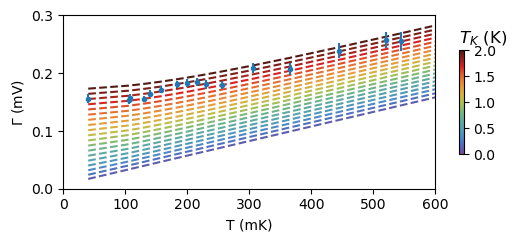

In [24]:
def plot_gamma_kondo_curves(fit_results, kB, tol_cmap, gamma_kondo):
    """
    Plots the gamma_kondo curves and experimental data.
    
    Args:
        fit_results (dict): Dictionary containing 'Teffs', 'width', and 'width_err'.
        kB (float): Boltzmann constant.
        tol_cmap (function): Function to get colormap.
        gamma_kondo (function): Function to compute gamma_kondo.
    """
    # Extract data from fit_results
    T_effs = fit_results['Teffs']
    width = fit_results['width']
    width_err = fit_results['width_err']

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(6, 9/4))

    # Plot gamma_kondo curves for a range of scaling factors (from 0 to 2 K)
    for i in np.linspace(0, 2, 20):
        colour = tol_cmap('rainbow_PuBr')(i / 2)
        ax.plot(T_effs * 1000, gamma_kondo(T_effs, i * kB), '--', color=colour, zorder=2)

    # Plot experimental data points with error bars
    ax.errorbar(T_effs[:-7] * 1000, width[:-7], yerr=width_err[:-7],
                ms=3, fmt='o', color='C1', zorder=3)

    # Format the y-axis ticks
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(np.round(ax.get_yticks() * 1e3, 2))
    ax.set_ylim(0.000, 0.0003)
    ax.set_ylabel(r'$\Gamma$ (mV)')
    ax.set_xlabel('T (mK)')
    ax.set_xlim(0, 600)

    # Create a colorbar to indicate the T_K scaling values (in K)
    scalarmappable = cm.ScalarMappable(cmap=tol_cmap('rainbow_PuBr'), norm=plt.Normalize(0, 2))
    scalarmappable.set_array([])
    cbar = plt.colorbar(scalarmappable, ax=ax, shrink=0.6, ticks=[0, 0.5, 1, 1.5, 2])
    cbar.ax.set_title(r'$T_K$ (K)', loc='left', pad=5)

    # Display the plot
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import matplotlib.cm as cm

def plot_gamma_kondo_curves(fit_results, kB, tol_cmap, gamma_kondo):
    """
    Plots the gamma_kondo curves and experimental data.
    
    Args:
        fit_results (dict): Dictionary containing 'Teffs', 'width', and 'width_err'.
        kB (float): Boltzmann constant.
        tol_cmap (function): Function to get colormap.
        gamma_kondo (function): Function to compute gamma_kondo.
    """
    # Extract data from fit_results
    T_effs = fit_results['Teffs']
    width = fit_results['width']
    width_err = fit_results['width_err']

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(6, 9/4))

    # Plot gamma_kondo curves for a range of scaling factors (from 0 to 2 K)
    for i in np.linspace(0, 2, 20):
        colour = tol_cmap('rainbow_PuBr')(i / 2)
        ax.plot(T_effs * 1000, gamma_kondo(T_effs, i * kB), '--', color=colour, zorder=2)

    # Plot experimental data points with error bars
    ax.errorbar(T_effs[:-7] * 1000, width[:-7], yerr=width_err[:-7],
                ms=3, fmt='o', color='C0', zorder=3)

    # Format the y-axis ticks
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(np.round(ax.get_yticks() * 1e3, 2))
    ax.set_ylim(0.000, 0.0003)
    ax.set_ylabel(r'$\Gamma$ (mV)')
    ax.set_xlabel('T (mK)')
    ax.set_xlim(0, 600)

    # Create a colorbar to indicate the T_K scaling values (in K)
    scalarmappable = cm.ScalarMappable(cmap=tol_cmap('rainbow_PuBr'), norm=plt.Normalize(0, 2))
    scalarmappable.set_array([])
    cbar = plt.colorbar(scalarmappable, ax=ax, shrink=0.6, ticks=[0, 0.5, 1, 1.5, 2])
    cbar.ax.set_title(r'$T_K$ (K)', loc='left', pad=5)

    # Display the plot
    plt.show()

plot_gamma_kondo_curves(fit_results, kB, tol_cmap, gamma_kondo)

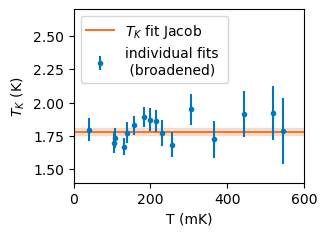

In [25]:
def plot_individual_fit_T_ADR():
    """
    Plot the individual fit T_ADR curve and compare it to the Jacobian fit.

    This function:
      - Loads fit parameters and their errors from external files.
      - Extracts the Kondo peak width (assumed to be in the third column) and its uncertainty.
      - Converts the temperature array (Ts, assumed in mK) to Kelvin.
      - Computes the individual Kondo widths using the function `individual_Tk_er`
        (which returns an array of uncertainties using the `uncertainties` package).
      - Plots:
          - A horizontal line (and error band) representing the Jacobian fit T_K (global variables `Jacob_Tk` and `Jacob_error` are assumed).
          - Error-bar markers for the individual fits (converted to Kelvin using the Boltzmann constant `kB`).
      - Returns nothing, but you can easily modify the function to return the computed widths for future use.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import constants
    from uncertainties import unumpy

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(5.94/2, 9/4))
    
    # Set color palette (assuming tol_cset is defined elsewhere).
    color = tol_cset('vibrant')

    Jacob_Tk= fit_results['Jacob_Tk']
    Jacob_error=fit_results['Jacob_error']
    
    # Load pre-saved fit parameters and errors.
    params = params_conv
    errors = errors_conv
    
    # Extract the width (third column, index 2) and its error.
    width = np.array([params[i][2] for i in range(len(params))])
    width_er = np.array([errors[i][2] for i in range(len(errors))])
    
    # Convert temperatures in Ts (assumed to be a global array in mK) to Kelvin.
    T_kelvin = np.array([temp / 1000 for temp in Ts])
    
    # Compute uncertain Kondo widths using individual_Tk_er:
    gammas_uncertain = individual_Tk_er(T_kelvin, unumpy.uarray(width, width_er))
    gammas = unumpy.nominal_values(gammas_uncertain)
    gammas_er = unumpy.std_devs(gammas_uncertain)
    
    # Plot a horizontal line for the Jacobian fit T_K (assumed global variable).
    ax.axhline(y=Jacob_Tk, color=color[0], label=r'$T_K$ fit Jacob', zorder=0)
    
    # Fill between to indicate the Jacobian fit error (global variables Jacob_Tk and Jacob_error are assumed).
    ax.fill_between(np.linspace(0, 1, num=10),
                    Jacob_Tk - Jacob_error, Jacob_Tk + Jacob_error,
                    color=color[0], alpha=0.2, zorder=0)
    
    # Plot the individual fits with error bars.
    # (Here we plot all but the last 7 points; adjust slicing if needed.)
    ax.errorbar(T_kelvin[:-7], gammas[:-7] / constants.physical_constants['Boltzmann constant in eV/K'][0],
                fmt='o', ms=3, yerr=gammas_er[:-7] / constants.physical_constants['Boltzmann constant in eV/K'][0],
                color=color[1], label='individual fits \n (broadened)')
    
    # Set axis labels and limits.
    ax.set_ylabel(r'$T_K$ (K)')
    ax.set_xlabel(r'T (mK)')
    ax.set_xlim(left=0, right=0.6)
    ax.set_ylim(1.4, 2.7)
    
    # Set x-tick labels (convert from K back to mK for display)
    ax.set_xticks(ax.get_xticks(), np.round(ax.get_xticks() * 1e3).astype(int))
    
    ax.legend(loc='upper left')
    
    plt.show()

# Call the function to generate the plot.
plot_individual_fit_T_ADR()


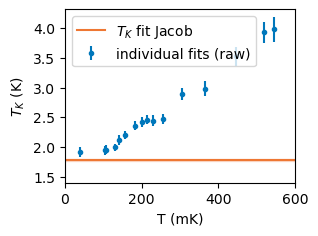

In [26]:
def plot_individual_fit_unconvoluted():
    """
    Plot the individual unconvoluted T_ADR fits.

    This function:
      - Loads fit parameters and errors from external files.
      - Extracts the Kondo peak width (assumed in the third column) and its uncertainty.
      - Converts the global temperature array (Ts, in mK) to Kelvin.
      - Computes the uncertain Kondo widths using `individual_Tk_er` and the uncertainties package.
      - Plots a horizontal line for the Jacobian fit T_K (with its error band) and error bars for the individual fits.
      - Saves the resulting plot to a specified file.
    
    Global variables that must be defined externally:
      - Ts: an array of temperatures in mK.
      - Jacob_Tk, Jacob_error: the Jacobian fit T_K value and its uncertainty.
      - color: a color palette (from tol_cset).
      - kB: Boltzmann constant in eV/K.
      - individual_Tk_er: function returning uncertain Kondo widths.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import constants
    from uncertainties import unumpy

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(5.94/2, 9/4))
    
    # Load unconvoluted fit parameters and their errors from files.
    params = params_unconv
    errors = errors_unconv

    Jacob_Tk= fit_results['Jacob_Tk']
    Jacob_error=fit_results['Jacob_error']
    
    # Extract width (assumed to be in the 3rd column) and its error.
    width = np.array([params[i][2] for i in range(len(params))])
    width_er = np.array([errors[i][2] for i in range(len(errors))])
    
    # Convert temperatures in Ts (mK) to Kelvin.
    T_kelvin = np.array([temp / 1000 for temp in Ts])
    
    # Compute the uncertain Kondo widths using individual_Tk_er.
    gammas_uncertain = individual_Tk_er(T_kelvin, unumpy.uarray(width, width_er))
    gammas = unumpy.nominal_values(gammas_uncertain)
    gammas_er = unumpy.std_devs(gammas_uncertain)
    
    # Plot the Jacobian fit T_K as a horizontal line and its error band.
    ax.axhline(y=Jacob_Tk, color=color[0], label=r'$T_K$ fit Jacob', zorder=0)
    ax.fill_between(np.linspace(0, 1, num=10),
                    Jacob_Tk - Jacob_error, Jacob_Tk + Jacob_error,
                    color=color[0], alpha=0.2, zorder=0)
    
    # Plot the individual unconvoluted fits with error bars.
    # Exclude the last 7 points (adjust slicing as needed).
    ax.errorbar(T_kelvin[:-7], gammas[:-7] / constants.physical_constants['Boltzmann constant in eV/K'][0],
                fmt='o', ms=3, yerr=gammas_er[:-7] / constants.physical_constants['Boltzmann constant in eV/K'][0],
                color=color[1], label='individual fits (raw)')
    
    # Set axis labels and limits.
    ax.set_ylabel(r'$T_K$ (K)')
    ax.set_xlabel(r'T (mK)')
    ax.set_xlim(left=0, right=0.6)
    ax.set_ylim(bottom=1.4)
    ax.locator_params(axis='y', nbins=6)
    
    # Set x-tick labels: convert Kelvin ticks back to mK.
    ax.set_xticks(ax.get_xticks(), np.rint(1e3 * ax.get_xticks()).astype(int))
    
    ax.legend(loc='upper left')
    
    plt.show()

# Execute the function to produce the plot.
plot_individual_fit_unconvoluted()


6. **Hurwitz Model:**

In [ ]:
def run_hurwitz_fit(temperatures_mK, offset_kelvin=0.045, lock_in=0.02, range_min=-0.0006, range_max=0.0006):
    """
    Runs the Hurwitz fit analysis script for a list of temperatures.
    
    Args:
        temperatures_mK (np.array): Array of temperature values in mK.
        offset_kelvin (float): Offset to add to the temperature in Kelvin. Default is 0.045 K.
        lock_in (float): Lock-in parameter value. Default is 0.02.
        range_min (float): Minimum range value. Default is -0.0006.
        range_max (float): Maximum range value. Default is 0.0006.
    """
    for temp_mK in temperatures_mK:
        # Convert temperature from mK to Kelvin, adding the offset
        temp_kelvin = temp_mK / 1000.0 + offset_kelvin
        
        # Construct the file path (temperature formatted as a 3-digit number with leading zeros)
        file_path = f"original_specs/{temp_mK:03d}mK.dat"
        
        # Run the Hurwitz fit analysis script with the given parameters
        command = [
            "python", "hurwitzfit.py", file_path, "3", str(temp_kelvin),
            f"--lock-in={lock_in}", f"--range={range_min},{range_max}"
        ]
        subprocess.run(command, check=True)

#usage
temperatures_mK = np.array([40, 105, 107, 130, 140, 157, 183, 200, 215, 230, 255, 305, 365, 445, 520, 545, 580, 610, 640, 670, 700, 740, 760])
run_hurwitz_fit(temperatures_mK)

Scaled fit parameter: 0.41241020766806985


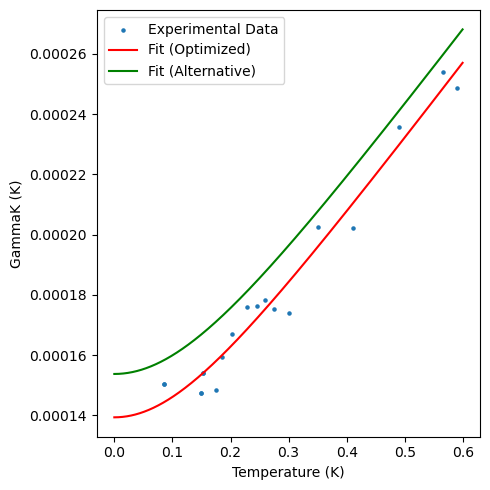

In [27]:
def load_and_plot_gammaK(file_path, gamma_kondo):
    """
    Loads experimental data, fits the gamma_kondo model, and plots the results.
    
    Args:
        file_path (str): Path to the data file.
        gamma_kondo (function): Function to compute gamma_kondo.
    """
    # Load experimental data (columns: temperature and GammaK) and convert GammaK from mK to K
    temp, GammaK = np.loadtxt(file_path, usecols=(0, 1), unpack=True)
    GammaK /= 1e3

    # Use GammaK for further analysis if needed
    Tkondo = GammaK

    # Generate plotting range
    t_range = np.linspace(0, 0.6, 1000)

    # Create figure and plot experimental data (only for temp < 0.6 K)
    fig = plt.figure(figsize=(5, 5))
    mask = temp < 0.6
    plt.scatter(temp[mask], GammaK[mask], s=5, label='Experimental Data')

    # Fit the gamma_kondo model to the data with an initial guess for the parameter
    popt2, pcov2 = optimize.curve_fit(gamma_kondo, temp[mask], GammaK[mask], p0=[1e-5])

    # Plot the optimized model fit
    mask_range = t_range < 0.6
    plt.plot(t_range[mask_range], gamma_kondo(t_range[mask_range], *popt2),
             label='Fit (Optimized)', color='red')

    # Plot an alternative model fit using a predefined scaling parameter
    kB = constants.physical_constants['Boltzmann constant in eV/K'][0]
    plt.plot(t_range[mask_range], gamma_kondo(t_range[mask_range], 0.455 * 3.92 * kB),
             label='Fit (Alternative)', color='green')

    print("Scaled fit parameter:", popt2[0] / 3.92 / kB)

    plt.xlabel("Temperature (K)")
    plt.ylabel("GammaK (K)")
    plt.legend()
    plt.tight_layout()
    plt.show()


file_path = 'Hurwizt-Fano fits/GammaK_vs_temp.dat'
load_and_plot_gammaK(file_path, gamma_kondo)